In [1]:
import os

os.environ['HDF5_DISABLE_VERSION_CHECK'] = "1"

import datetime as dt 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr

from sklearn import metrics

from eofs.xarray import Eof
from esem import rf_model

from utils import *

In [2]:
# path to save the netcdf file
path_output ='outputs_ssp245_prediction_ESEm.nc'


In [3]:
train_files = [ "historical", "ssp585", "ssp126", "ssp370", ]
# Create training and testing arrays
X, solvers = create_predictor_data(train_files)
Y = create_predictdand_data(train_files)



In [4]:

rf_tas = rf_model(X, Y['tas'], random_state=0, bootstrap=True, max_features='auto', **{'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 7,  'max_depth': 5,})
rf_pr = rf_model(X, Y['pr'], random_state=0, bootstrap=True, max_features='auto', **{'n_estimators': 150, 'min_samples_split': 15, 'min_samples_leaf': 8,'max_depth': 40,})
rf_pr90 = rf_model(X, Y['pr90'], random_state=0, bootstrap=True, max_features='auto',**{'n_estimators': 250, 'min_samples_split': 15, 'min_samples_leaf': 12,'max_depth': 25,})
rf_dtr = rf_model(X, Y["diurnal_temperature_range"], random_state=0, bootstrap=True, max_features='auto',**{'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 12, 'max_depth': 20,})

rf_tas.train()
rf_pr.train()
rf_pr90.train()
rf_dtr.train()


2022-08-20 13:33:44.862831: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove 

In [5]:
## Test on SSP245

X_test = get_test_data('ssp245', solvers)
Y_test = create_predictdand_data(['ssp245'])

tas_truth = Y_test["tas"]
pr_truth = Y_test["pr"]
pr90_truth = Y_test["pr90"]
dtr_truth = Y_test["diurnal_temperature_range"]


In [6]:
m_out_tas, _ = rf_tas.predict(X_test)
m_out_pr, _ = rf_pr.predict(X_test)
m_out_pr90, _ = rf_pr90.predict(X_test)
m_out_dtr, _ = rf_dtr.predict(X_test)


In [7]:

xr_output = xr.Dataset(dict(tas=m_out_tas, pr=m_out_pr, pr90=m_out_pr90, diurnal_temperature_range=m_out_dtr)).assign_coords(time=m_out_tas.sample + 2014)
#save output to netcdf 
xr_output.to_netcdf(path_output,'w')

In [8]:
print(f"RMSE: {get_rmse(tas_truth[35:], m_out_tas[35:]).mean()}")
print("\n")

print(f"RMSE: {get_rmse(dtr_truth[35:], m_out_dtr[35:]).mean()}")
print("\n")

print(f"RMSE: {get_rmse(pr_truth[35:], m_out_pr[35:]).mean()}")
print("\n")

print(f"RMSE: {get_rmse(pr90_truth[35:], m_out_pr90[35:]).mean()}")

RMSE: 0.5595709961735882


RMSE: 0.15835733899023294


RMSE: 0.5394265869027367


RMSE: 1.5462448434582696


In [9]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, check_scoring, mean_squared_error

def get_rmse_array(truth, pred):
    print(truth.shape, pred.shape)
    weights = np.cos(np.deg2rad(truth.lat))

    return np.sqrt(((truth - pred.reshape(-1, 96,144))**2).weighted(weights).mean(['lat', 'lon'])).data.mean()


In [10]:
%%time
pr_result = permutation_importance(
    rf_pr.model.model, X_test[35:], pr_truth.sel(time=slice(2050,None)), n_repeats=10, random_state=42, n_jobs=1, scoring=make_scorer(get_rmse_array))


(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
CPU times: user 17 s, sys: 322 ms, total: 17.3 s
Wall time: 17.3 s


/Users/watson-parris/miniconda3/envs/climatebench/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [11]:
importances = rf_pr.model.model.feature_importances_

In [12]:
feature_names = list(X.columns)

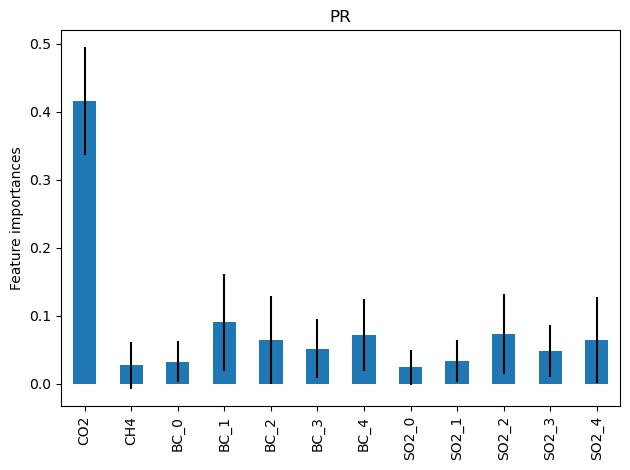

In [13]:
std = np.std([tree.feature_importances_ for tree in rf_pr.model.model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("PR")
ax.set_ylabel("Feature importances")
fig.tight_layout()